# Building Logistic Regression Workflow


This workbook provides a suggested workflow for building a **logistic regression model**. The process begins with **Exploratory Data Analysis (EDA)** and verifying **model assumptions**. We will then proceed by **inspecting the dataset**, **balancing classes**, **transforming features**, and **splitting the data into training and test sets**. Next, we apply **one-hot encoding** to categorical variables, and finally, perform **model evaluation** using metrics such as **F1 score**, **recall**, and others.

Please refer to the summary section for a comprehensive overview of the steps.

## DATA LOAD

In [61]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Import packages for data preprocessing
import sklearn
print(sklearn.__version__)
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

1.5.2


In [2]:
data = pd.read_csv("/Users/mycklandmatthew/Documents/Project Computer Science/Analytics 📊/2023_07_Coursera_Advanced Google Analytics/tiktok-truth-serum/data/tiktok_dataset.csv")

# EDA and Model Assumption


we handled the missing values previously with trimming the value and therefore this process is not replicated

In [3]:
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [4]:
# check missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [5]:
data = data.dropna()
data.isna().sum()

#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

In [6]:
#check duplicated
data.duplicated().sum()

0

## Checking Outliers

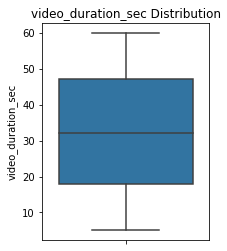

In [7]:

# Create a boxplot to visualize distribution of `video_duration_sec`
fig, ax = plt.subplots(figsize=(3,4))
sns.boxplot(data=data, y='video_duration_sec', ax=ax)
ax.set_title('video_duration_sec Distribution')

plt.show()

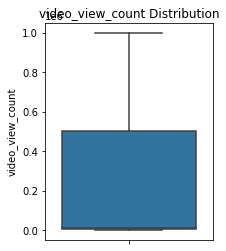

In [8]:
# Create a boxplot to visualize distribution of `video_view_count`
fig, ax = plt.subplots(figsize=(3,4))
sns.boxplot(data=data, y='video_view_count', ax=ax)
ax.set_title('video_view_count Distribution')

plt.show()

video_view_count are not normally distributed and seemed to be very skewed with some outliers

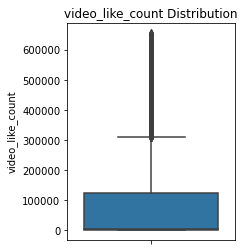

In [9]:
# Create a boxplot to visualize distribution of `video_like_count`
fig, ax = plt.subplots(figsize=(3,4))
sns.boxplot(data=data, y='video_like_count', ax=ax)
ax.set_title('video_like_count Distribution')

plt.show()

video_like_count also not normally distributed and seemed to be very skewed 

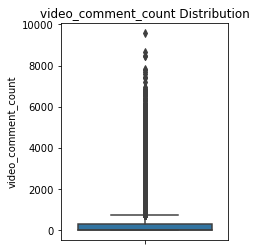

In [10]:
# Create a boxplot to visualize distribution of `video_comment_count`
fig, ax = plt.subplots(figsize=(3,4))
sns.boxplot(data=data, y='video_comment_count', ax=ax)
ax.set_title('video_comment_count Distribution')

plt.show()


video_comment_count boxplot showed that this is also not normally distributed and seemed to have extreme outliers

In [11]:
# Handle outliers for `video_like_count`
q1 = data['video_like_count'].quantile(0.25)
q3 = data['video_like_count'].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - (1.5*iqr)
upper_limit = q3 + (1.5*iqr)

# Change outlier values to match the upper limit 
data.loc[data['video_like_count'] > upper_limit, 'video_like_count'] = upper_limit

In [12]:
# Handle outliers for `video_comment_count`
q1 = data['video_comment_count'].quantile(0.25)
q3 = data['video_comment_count'].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - (1.5*iqr)
upper_limit = q3 + (1.5*iqr)

# Change outlier values to match the upper limit 
data.loc[data['video_comment_count'] > upper_limit, 'video_comment_count'] = upper_limit

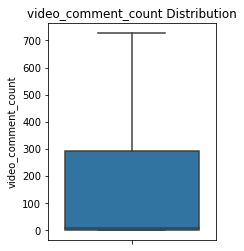

In [13]:
# Recreate a boxplot to visualize distribution of `video_comment_count`
fig, ax = plt.subplots(figsize=(3,4))
sns.boxplot(data=data, y='video_comment_count', ax=ax)
ax.set_title('video_comment_count Distribution')

plt.show()

it's still better although given more time we can add future improvement for handling outlier rather than using winsorizing. We need to check the proportion of the data.

## Class Balance

In model validation, class balance is crucial. In logistic regression,  it affects the model’s predictions and evaluation metrics.

In [14]:
# Check class balance for verified_status
data['verified_status'].value_counts(normalize=True)

not verified    0.93712
verified        0.06288
Name: verified_status, dtype: float64

By setting normalize=True, the output shows the proportion of each class by giving percentage distribution of verified and unverified status in databses. Here we see that 93.71% comes from not_verified while only 6.2% comes from veriried class. 

This will lead to biased model within the majority class. Therefore we need to handle these imbalances before proceeding with the model building

In [15]:
# Identify data points from majority and minority classes
data_majority = data[data["verified_status"] == "not verified"]
data_minority = data[data["verified_status"] == "verified"]

# Upsample the minority class (which is "verified")
data_minority_upsampled = resample(data_minority,
                                 replace=True,                 # to sample with replacement
                                 n_samples=len(data_majority), # to match majority class
                                 random_state=0)               # to create reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

# Display new class counts
data_upsampled["verified_status"].value_counts()

not verified    17884
verified        17884
Name: verified_status, dtype: int64

This has shown that the class is no longer biased

Now we can get the average video_transcription_text length for videos posted by verified accounts and the average video_transcription_text length for videos posted by unverified accounts.

In [16]:
# Get the average `video_transcription_text` length for claims and the average `video_transcription_text` length for opinions
data_upsampled[["verified_status", "video_transcription_text"]].groupby(by="verified_status")[["video_transcription_text"]].agg(func=lambda array: np.mean([len(text) for text in array]))

,video_transcription_text
verified_status,
not verified,89.401141
verified,84.569559


In [17]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data_upsampled["text_length"] = data_upsampled["video_transcription_text"].apply(func=lambda text: len(text))

In [18]:
# Display first few rows of dataframe after adding new column
data_upsampled.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Visualize the distribution of video_transcription_text length for videos posted by verified accounts and videos posted by unverified accounts.

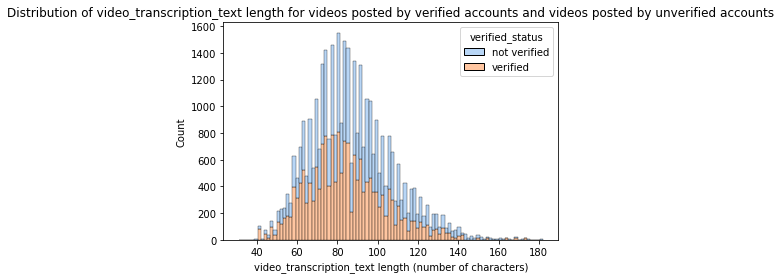

In [19]:
# Visualize the distribution of `video_transcription_text` length for videos posted by verified accounts and videos posted by unverified accounts
# Create two histograms in one plot
sns.histplot(data=data_upsampled, stat="count", multiple="stack", x="text_length", kde=False, palette="pastel", hue="verified_status", element="bars", legend=True)
plt.title("Seaborn Stacked Histogram")
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for videos posted by verified accounts and videos posted by unverified accounts")
plt.show()

The length of video transcription text looks the same for both groups so exclude this feature in the model.

## Correlation Variable

In [20]:
# Code a correlation matrix to help determine most correlated variables
data_upsampled.corr()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
#,1.000000,-0.000853,-0.011729,-0.697007,-0.626385,-0.504015,-0.487096,-0.608773,-0.193677
video_id,-0.000853,1.000000,0.011859,0.002554,0.005993,0.010515,0.008753,0.012674,-0.007083
video_duration_sec,-0.011729,0.011859,1.000000,0.013589,0.004494,0.002206,0.003989,-0.001086,-0.002981
video_view_count,-0.697007,0.002554,0.013589,1.000000,0.856937,0.711313,0.690048,0.748361,0.244693
video_like_count,-0.626385,0.005993,0.004494,0.856937,1.000000,0.832146,0.805543,0.818032,0.216693
video_share_count,-0.504015,0.010515,0.002206,0.711313,0.832146,1.000000,0.710117,0.671335,0.171651
video_download_count,-0.487096,0.008753,0.003989,0.690048,0.805543,0.710117,1.000000,0.793668,0.173396
video_comment_count,-0.608773,0.012674,-0.001086,0.748361,0.818032,0.671335,0.793668,1.000000,0.217661
text_length,-0.193677,-0.007083,-0.002981,0.244693,0.216693,0.171651,0.173396,0.217661,1.000000


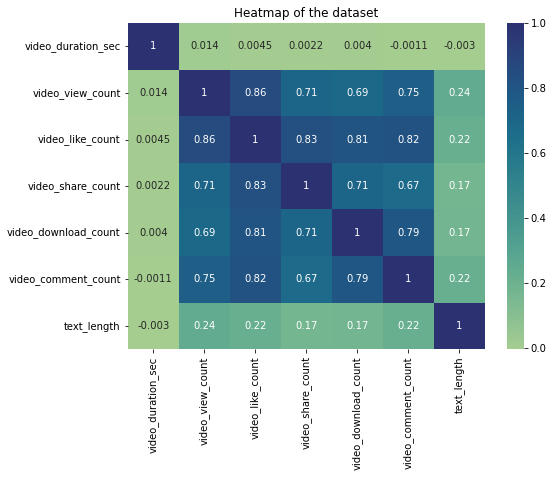

In [21]:
# Heatmap to see correlation of the data
plt.figure(figsize=(8, 6))
sns.heatmap(data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_like_count", "video_share_count", "video_download_count", "video_comment_count", "text_length"]].corr(), annot=True, cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()


Since model assumptions for logistics regression is no sever multicollinearilty among features, we see that video_view_count and video_like_count are strongly correlated (0.85 coef)

Therefore we can  build a logistic regression model that meets this assumption, and  exclude video_like_count. And among the variables that quantify video metrics, we keep video_view_count, video_share_count, video_download_count, and video_comment_count as features 

# Model Constructions


In [22]:
# Select outcome variable
y = data_upsampled["verified_status"]

In [23]:
# Select features
X = data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_share_count", "video_download_count", "video_comment_count"]]

# Display first few rows of features dataframe
X.head()

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_download_count,video_comment_count
0,59,claim,under review,343296.0,241.0,1.0,0.0
1,32,claim,active,140877.0,19034.0,1161.0,684.0
2,31,claim,active,902185.0,2858.0,833.0,329.0
3,25,claim,active,437506.0,34812.0,1234.0,584.0
4,19,claim,active,56167.0,4110.0,547.0,152.0


Note: 
The # and video_id columns are not included as features here, as they don’t appear useful for predicting whether a video presents a claim or an opinion. Additionally, video_like_count is excluded because it has a strong correlation with other features, as previously mentioned. This exclusion also helps meet the logistic regression model’s requirement to avoid multicollinearity.

### Train-Test Split

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [25]:
# Get shape of each training and testing set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26826, 7), (8942, 7), (26826,), (8942,))

Notes:

The number of features (5) aligns between the training and testing sets.
The number of rows aligns between the features and the outcome variable for training (27009) and testing (27009).

### Encoding variables for X_train

In [26]:
X_train.dtypes

video_duration_sec        int64
claim_status             object
author_ban_status        object
video_view_count        float64
video_share_count       float64
video_download_count    float64
video_comment_count     float64
dtype: object

In [27]:
# Get unique values in `claim_status`
X_train["claim_status"].unique()

array(['opinion', 'claim'], dtype=object)

In [28]:
# Get unique values in `author_ban_status`
X_train["author_ban_status"].unique()

array(['active', 'under review', 'banned'], dtype=object)

both features have type objects. To implement the model using sklearn, the categoridcal features need to be made numeric (machine learning ready). we can do one-hot encoding

In [29]:
# Select the training features that needs to be encoded
X_train_to_encode = X_train[["claim_status", "author_ban_status"]]

# Display first few rows
X_train_to_encode.head()

,claim_status,author_ban_status
33058,opinion,active
20491,opinion,active
25583,opinion,active
18474,opinion,active
27312,opinion,active


In [30]:
# Set up an encoder for one-hot encoding the categorical features
X_encoder = OneHotEncoder(drop='first', sparse_output=False)


Notes:
each unique value in categorical features is now represented as a separate binary column (0 or 1) in the transformed data.
encoder also drop the first category for each features, retain the information without redundancy

In [31]:
X_train_encoded = X_encoder.fit_transform(X_train_to_encode)

In [32]:
X_encoder

OneHotEncoder(drop='first', sparse_output=False)

In [33]:
# Get feature names from encoder
X_encoder.get_feature_names_out()

array(['claim_status_opinion', 'author_ban_status_banned',
       'author_ban_status_under review'], dtype=object)

In [34]:
# Display first few rows of encoded training features
X_train_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [35]:
# Place encoded training features (which is currently an array) into a dataframe
X_train_encoded_df = pd.DataFrame(data=X_train_encoded, columns=X_encoder.get_feature_names_out())

# Display first few rows
X_train_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [36]:
# Display first few rows of `X_train` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
X_train.drop(columns=['claim_status', 'author_ban_status']).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
33058,33,2252.0,23.0,4.0,0.0
20491,52,6664.0,550.0,53.0,2.0
25583,37,6327.0,257.0,3.0,0.0
18474,57,1702.0,28.0,0.0,0.0
27312,21,3842.0,101.0,1.0,0.0


In [37]:
# Concatenate `X_train` and `X_train_encoded_df` to form the final dataframe for training data (`X_train_final`)
X_train_final = pd.concat([X_train_encoded_df, X_train.drop(columns=['claim_status', 'author_ban_status']).reset_index(drop=True)], axis=1)

# Display first few rows
X_train_final.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
0,1.0,0.0,0.0,33,2252.0,23.0,4.0,0.0
1,1.0,0.0,0.0,52,6664.0,550.0,53.0,2.0
2,1.0,0.0,0.0,37,6327.0,257.0,3.0,0.0
3,1.0,0.0,0.0,57,1702.0,28.0,0.0,0.0
4,1.0,0.0,0.0,21,3842.0,101.0,1.0,0.0


### Encoding variable for y_variable

In [38]:
# Check data type of outcome variable
y_train.dtype

dtype('O')

In [39]:
# Get unique values of outcome variable
y_train.unique()

array(['verified', 'not verified'], dtype=object)

In [40]:
# Set up an encoder for one-hot encoding the categorical outcome variable
y_encoder = OneHotEncoder(drop='first', sparse_output=False)


In [41]:
# Encode the training outcome variable
# Notes:
#   - Adjusting the shape of `y_train` before passing into `.fit_transform()`, since it takes in 2D array
#   - Using `.ravel()` to flatten the array returned by `.fit_transform()`, so that it can be used later to train the model
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Display the encoded training outcome variable
y_train_final

array([1., 1., 1., ..., 1., 1., 0.])

Our model training function expects a 1D array for the target variable

### Constructing Logistic Model

In [42]:
# Construct a logistic regression model and fit it to the training set
log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train_final, y_train_final)


# Results and Evaluation 

Before we evaluate the model, we need to encode the categorical features in the testing set. Again we will do one-hot encoding.
This will have similar workflow with the training dataset

In [43]:
# Select the testing features that needs to be encoded
X_test_to_encode = X_test[["claim_status", "author_ban_status"]]

# Display first few rows
X_test_to_encode.head()

,claim_status,author_ban_status
21061,opinion,active
31748,opinion,active
20197,claim,active
5727,claim,active
11607,opinion,active


In [44]:
# Transform the testing features using the encoder
X_test_encoded = X_encoder.transform(X_test_to_encode)

# Display first few rows of encoded testing features
X_test_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [45]:
# Place encoded testing features (which is currently an array) into a dataframe
X_test_encoded_df = pd.DataFrame(data=X_test_encoded, columns=X_encoder.get_feature_names_out())

# Display first few rows
X_test_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0


In [46]:
# Display first few rows of `X_test` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
X_test.drop(columns=["claim_status", "author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
21061,41,2118.0,57.0,5.0,2.0
31748,27,5701.0,157.0,1.0,0.0
20197,31,449767.0,75385.0,5956.0,728.5
5727,19,792813.0,56597.0,5146.0,728.5
11607,54,2044.0,68.0,19.0,2.0


In [47]:
# Concatenate `X_test` and `X_test_encoded_df` to form the final dataframe for training data (`X_test_final`)
X_test_final = pd.concat([X_test.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_test_encoded_df], axis=1)

# Display first few rows
X_test_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,41,2118.0,57.0,5.0,2.0,1.0,0.0,0.0
1,27,5701.0,157.0,1.0,0.0,1.0,0.0,0.0
2,31,449767.0,75385.0,5956.0,728.5,0.0,0.0,0.0
3,19,792813.0,56597.0,5146.0,728.5,0.0,0.0,0.0
4,54,2044.0,68.0,19.0,2.0,1.0,0.0,0.0


In [52]:

# Check column alignment before prediction
assert (X_train_final.columns == X_test_final.columns).all(), "Column names do not match!"

In [50]:
train_cols = set(X_train_final.columns)
test_cols = set(X_test_final.columns)

missing_in_test = train_cols - test_cols
extra_in_test = test_cols - train_cols

print("Columns in training data but missing in test data:", missing_in_test)
print("Columns in test data but missing in training data:", extra_in_test)

Columns in training data but missing in test data: set()
Columns in test data but missing in training data: set()


In [51]:
X_test_final = X_test_final[X_train_final.columns]

### Testing the regression model to make predictions on the set

In [53]:
# Use the logistic regression model to get predictions on the encoded testing set
y_pred = log_clf.predict(X_test_final)

In [54]:
# Display the predictions on the encoded testing set
y_pred

array([1., 1., 0., ..., 1., 0., 1.])

In [55]:
# Display the true labels of the testing set
y_test

21061        verified
31748        verified
20197        verified
5727     not verified
11607    not verified
             ...     
14756    not verified
26564        verified
14800    not verified
35705        verified
31060        verified
Name: verified_status, Length: 8942, dtype: object

In [56]:
# Encode the testing outcome variable
# Notes:
#   - Adjusting the shape of `y_test` before passing into `.transform()`, since it takes in 2D array
#   - Using `.ravel()` to flatten the array returned by `.transform()`, so that it can be used later to compare with predictions
y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

# Display the encoded testing outcome variable
y_test_final

array([1., 1., 1., ..., 0., 1., 1.])

Confirm again that the dimensions of the training and testing sets are in alignment since additional features were added.

In [57]:
# Get shape of each training and testing set
X_train_final.shape, y_train_final.shape, X_test_final.shape, y_test_final.shape

((26826, 8), (26826,), (8942, 8), (8942,))

For our testing and trainining dataset now we have six features (6) aligns between the training and testing sets.
The number of rows aligns between the features and the outcome variable for training (27009) and testing (9003).

## Visualize the model Result

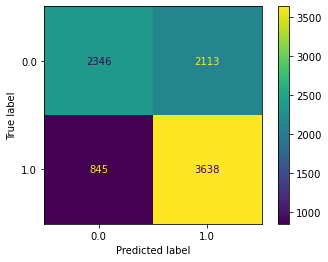

In [62]:

# Compute values for confusion matrix
log_cm = confusion_matrix(y_test_final, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

The confusion matrix provides insights into the performance of the model through four quadrants:

- **Upper-left quadrant**: Represents the number of True Negatives (TN) — the count of videos posted by unverified accounts that the model correctly classified as unverified.

- **Upper-right quadrant**: Represents the number of False Positives (FP) — the count of videos posted by unverified accounts that the model incorrectly classified as verified.

- **Lower-left quadrant**: Represents the number of False Negatives (FN) — the count of videos posted by verified accounts that the model incorrectly classified as unverified.

- **Lower-right quadrant**: Represents the number of True Positives (TP) — the count of videos posted by verified accounts that the model correctly classified as verified.

A perfect model would achieve all True Negatives and True Positives, with no False Negatives or False Positives.

To evaluate the performance of the logistic regression model, create a classification report that includes the following metrics:
- **Precision**
- **Recall**
- **F1-Score**
- **Accuracy**

In [63]:
# Create classification report for logistic regression model
target_labels = ["verified", "not verified"]
print(classification_report(y_test_final, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.74      0.53      0.61      4459
not verified       0.63      0.81      0.71      4483

    accuracy                           0.67      8942
   macro avg       0.68      0.67      0.66      8942
weighted avg       0.68      0.67      0.66      8942



The model performs better on the **“not verified”** class, as indicated by a higher recall and F1-score for this class. The overall accuracy is 67%, and both macro and weighted averages indicate similar performance across classes. 

The higher recall for **“not verified”** suggests that the model is more effective at identifying this class. However, the lower recall for **“verified”** means that the model misses a significant portion of **“verified”** instances.

### Model coefficients


In [64]:
# Get the feature names from the model and the model coefficients (which represent log-odds ratios)
# Place into a DataFrame for readability
pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Model Coefficient":log_clf.coef_[0]})

,Feature Name,Model Coefficient
0,claim_status_opinion,1.515282e+00
1,author_ban_status_banned,-5.725375e-01
2,author_ban_status_under review,-4.232011e-01
3,video_duration_sec,-3.310736e-03
4,video_view_count,-3.479943e-07
5,video_share_count,4.979994e-06
6,video_download_count,-7.223933e-05
7,video_comment_count,3.324650e-04


# Conclusion

**Key Takeaways:**

- The dataset includes some highly correlated variables, which could lead to multicollinearity issues. As a result, we excluded `video_like_count` from the model.
- We developed a logistic regression model to predict verified status based on various video features.
- Posting an opinion video is associated with an increase in the log-odds of a user being verified, with a model coefficient of 1.515, suggesting that verified users are more likely to post opinion-based content.
- Each additional second of video duration is associated with a small decrease in the log-odds of being verified, with a coefficient of -0.003, indicating a slight tendency for verified users to post shorter videos.
- For each increase in views, downloads, or comments on a video, the log-odds of a user being verified decrease slightly. This suggests that videos with high views, downloads, or comments are more likely to be posted by unverified users.
- The model provides a reasonable predictive performance:
  - **Accuracy**: 0.67 (percentage of correct predictions)
  - **Precision**: 0.68 (out of all times the model predicted "verified," how often it was correct)
  - **Recall**: 0.53 (out of all actual "verified" cases, how many the model identified correctly)

Overall, the logistic regression model shows decent predictive power for identifying verified accounts based on video features, with some trade-offs in recall.